# Day 08. Exercise 01
# Binary classifier. SVM. Decision tree

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

## 1. Preprocessing and logreg visualization

Read the file `am_pm.csv` to a dataframe from the previous exercise.

1. Draw a plot where the x-axis is `am`, the y-axis is `pm`, dots are the days, color depends on the target.
2. Add the decision boundary of logistic regression to the plot.
3. Draw the same plot (with the boundary), but the color should depend this time on the predictions.

Now it should be clear for you how the logistic regression works.

In [2]:
df = pd.read_csv('../data/am_pm.csv')
df.head()

,Unnamed: 0,date,am,pm,target,predict
0,0,2020-04-17,21,2,working_day,weekend
1,1,2020-04-18,1,68,weekend,working_day
2,2,2020-04-19,18,15,weekend,working_day
3,3,2020-04-20,2,23,working_day,working_day
4,4,2020-04-21,0,25,working_day,working_day


In [3]:
model = LogisticRegression(random_state=21, fit_intercept=False)
X = df[['am', 'pm']]
y = df['target']
model.fit(X, y)

LogisticRegression(fit_intercept=False, random_state=21)

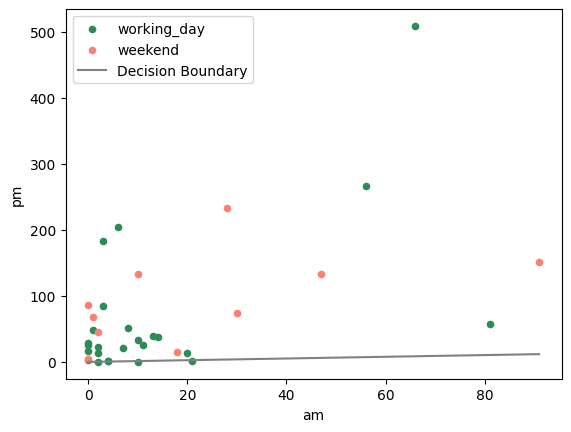

In [4]:
ax = df[df['target'] == 'working_day'].plot.scatter(x='am', y='pm', color='seagreen', label='working_day')
df[df['target'] == 'weekend'].plot.scatter(x='am', y='pm', color='salmon', label='weekend', ax=ax)

w1, w2 = model.coef_[0]
b = model.intercept_[0]
x_vals = np.linspace(df['am'].min(), df['am'].max(), 100)
y_vals = -(w1 * x_vals + b) / w2
ax.plot(x_vals, y_vals, color='grey', label='Decision Boundary')
ax.legend()

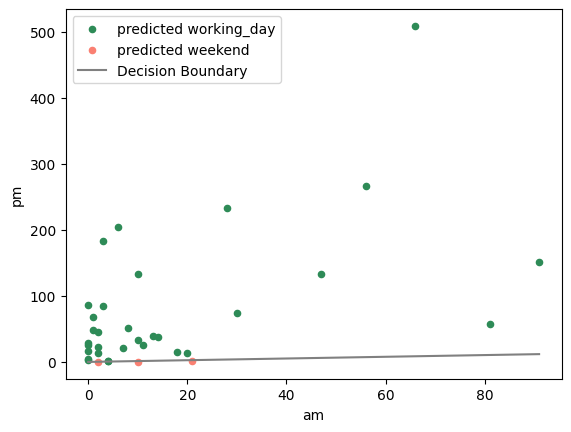

In [5]:
df['predict'] = model.predict(X)
ax2 = df[df['predict'] == 'working_day'].plot.scatter(x='am', y='pm', color='seagreen', label='predicted working_day')
df[df['predict'] == 'weekend'].plot.scatter(x='am', y='pm', color='salmon', label='predicted weekend', ax=ax2)
ax2.plot(x_vals, y_vals, color='grey', label='Decision Boundary')
ax2.legend()

## 2. Standardizing and logreg

Linear models can be sensitive to the scale of your variables. You make it easier for them to find the optimal solution when you scale your features.

1. Apply `StandardScaler` to `X` and train logistic regression again with the same parameters.
2. Calculate `accuracy` for the new model. Did it get better than a naive classifier with the most popular class?
3. Draw the plots that were described above but for the new model.

In [6]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [7]:
model.fit(scaled_X, y)

LogisticRegression(fit_intercept=False, random_state=21)

In [8]:
most_common = df['target'].mode()[0]
naive_preds = pd.Series(most_common, index=df.index)
accuracy_naive = accuracy_score(df['target'], naive_preds)
accuracy_naive

0.7142857142857143

In [9]:
df['predict'] = model.predict(scaled_X)
accuracy = accuracy_score(df['target'], df['predict'])
accuracy

0.7428571428571429

ANSWER: yes, it got better

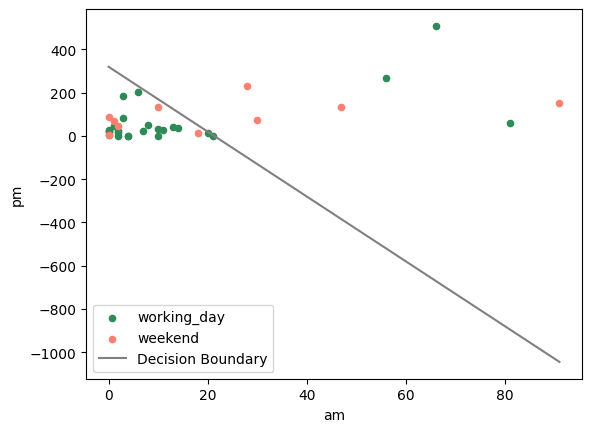

In [10]:
ax = df[df['target'] == 'working_day'].plot.scatter(x='am', y='pm', color='seagreen', label='working_day')
df[df['target'] == 'weekend'].plot.scatter(x='am', y='pm', color='salmon', label='weekend', ax=ax)

w1, w2 = model.coef_[0]
b = model.intercept_[0]

x_vals = np.linspace(df['am'].min(), df['am'].max(), 100)
x_scaled = (x_vals - scaler.mean_[0]) / scaler.scale_[0]
y_scaled = -(w1 * x_scaled + b) / w2
y_vals = y_scaled * scaler.scale_[1] + scaler.mean_[1]
ax.plot(x_vals, y_vals, color='grey', label='Decision Boundary')
ax.legend()

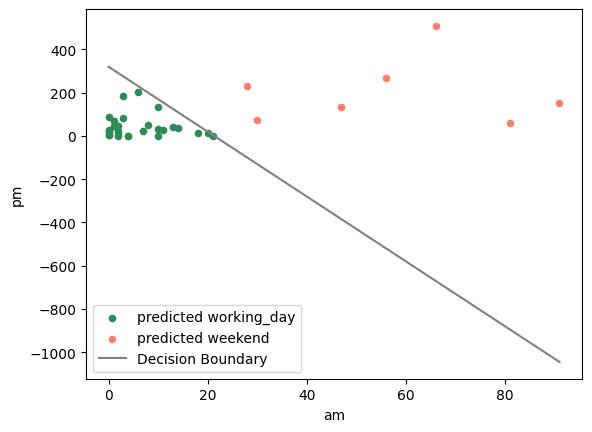

In [11]:
ax2 = df[df['predict'] == 'working_day'].plot.scatter(x='am', y='pm', color='seagreen', label='predicted working_day')
df[df['predict'] == 'weekend'].plot.scatter(x='am', y='pm', color='salmon', label='predicted weekend', ax=ax2)
ax2.plot(x_vals, y_vals, color='grey', label='Decision Boundary')
ax2.legend()

## 3. SVM

1. Apply `SVC` model to the scaled dataframe using parameters `probability=True`, `random_state=21`.
2. Calculate `accuracy`.
3. Try different kernels, find the best in terms of accuracy.
4. Draw both plots again with the decisions boundary to see how this algorithm works.

In [12]:
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

In [13]:
model = SVC(probability=True, random_state=21)
model.fit(scaled_X, y_encoded)

SVC(probability=True, random_state=21)

In [14]:
y_pred = model.predict(scaled_X)
accuracy = accuracy_score(y_encoded, y_pred)
accuracy

0.7428571428571429

In [15]:
best_acc = 0
best_kernel = None
best_model = None

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    model = SVC(probability=True, random_state=21, kernel=kernel)
    model.fit(scaled_X, y_encoded)
    y_pred = model.predict(scaled_X)
    accuracy = accuracy_score(y_encoded, y_pred)
    print(f'kernel: {kernel}, accuracy: {accuracy}')
    if accuracy > best_acc:
        best_acc = accuracy
        best_kernel = kernel
        best_model = model

kernel: linear, accuracy: 0.7142857142857143
kernel: poly, accuracy: 0.7428571428571429
kernel: rbf, accuracy: 0.7428571428571429
kernel: sigmoid, accuracy: 0.6857142857142857


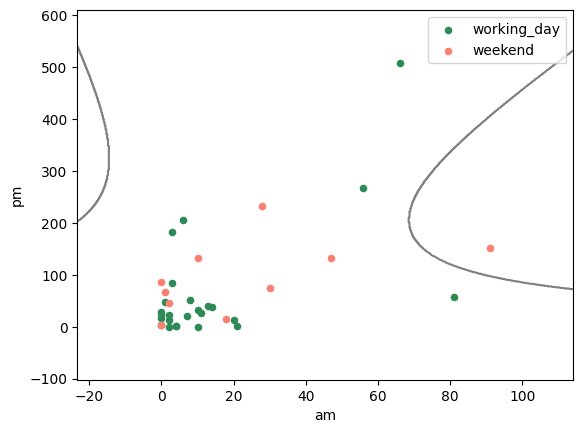

In [16]:
x_min, x_max = scaled_X[:, 0].min() - 1, scaled_X[:, 0].max() + 1
y_min, y_max = scaled_X[:, 1].min() - 1, scaled_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
grid_scaled = np.c_[xx.ravel(), yy.ravel()]
Z = best_model.predict(grid_scaled).reshape(xx.shape)

xx_real = xx * scaler.scale_[0] + scaler.mean_[0]
yy_real = yy * scaler.scale_[1] + scaler.mean_[1]

fig, ax = plt.subplots()
df[df['target'] == 'working_day'].plot.scatter(x='am', y='pm', color='seagreen', label='working_day', ax=ax)
df[df['target'] == 'weekend'].plot.scatter(x='am', y='pm', color='salmon', label='weekend', ax=ax)
ax.contour(xx_real, yy_real, Z, levels=[0.5], colors='grey')
plt.legend()

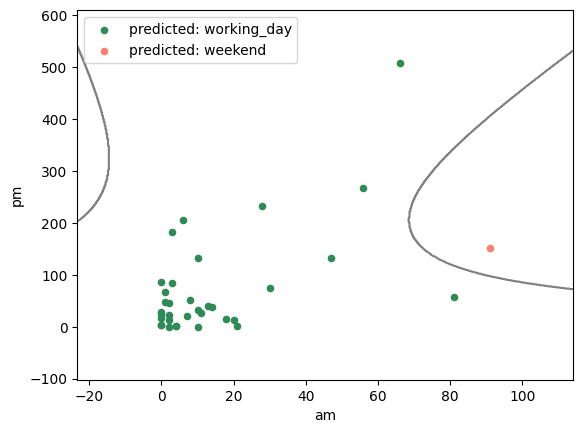

In [17]:
df['prediction'] = le.inverse_transform(best_model.predict(scaled_X))

fig, ax = plt.subplots()
df[df['prediction'] == 'working_day'].plot.scatter(x='am', y='pm', color='seagreen', label='predicted: working_day', ax=ax)
df[df['prediction'] == 'weekend'].plot.scatter(x='am', y='pm', color='salmon', label='predicted: weekend', ax=ax)
ax.contour(xx_real, yy_real, Z, levels=[0.5], colors='grey')
plt.legend()
plt.show()

## 4. Decision tree

1. Apply `DecisionTreeClassifier` to the scaled dataframe using parameters `max_depth=4`, `random_state=42`.
2. Calculate accuracy.
3. Try different values of `max_depth`.
4. Draw both plots again with the decisions boundary to see how this algorithm works.
5. Using method `.plot_tree()` visualize the decision tree itself. It is another way of thinking about how the algorithm works.
6. How many leaves in the visualized tree label days as working days? Put your answer in the markdown cell in the end of the section.

In [18]:
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(scaled_X, y_encoded)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [19]:
y_pred = model.predict(scaled_X)
accuracy = accuracy_score(y_encoded, y_pred)
accuracy

0.9428571428571428

In [20]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(scaled_X, y_encoded)
    y_pred = model.predict(scaled_X)
    accuracy = accuracy_score(y_encoded, y_pred)
    print(f"max_depth={depth}, accuracy={accuracy}")

max_depth=1, accuracy=0.7714285714285715
max_depth=2, accuracy=0.8571428571428571
max_depth=3, accuracy=0.8857142857142857
max_depth=4, accuracy=0.9428571428571428
max_depth=5, accuracy=0.9714285714285714
max_depth=6, accuracy=1.0
max_depth=7, accuracy=1.0
max_depth=8, accuracy=1.0
max_depth=9, accuracy=1.0


In [21]:
best_model = DecisionTreeClassifier(max_depth=6, random_state=42)
best_model.fit(scaled_X, y_encoded)

DecisionTreeClassifier(max_depth=6, random_state=42)

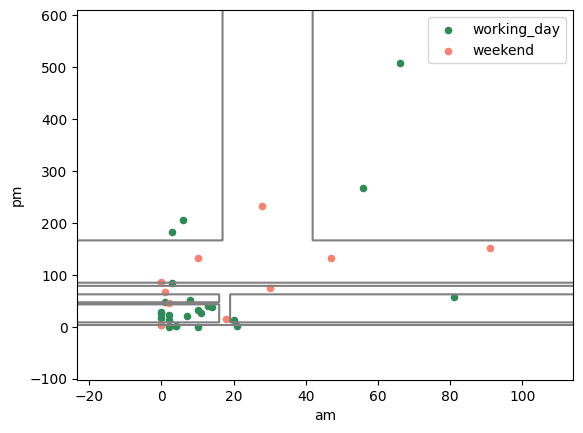

In [22]:
x_min, x_max = scaled_X[:, 0].min() - 1, scaled_X[:, 0].max() + 1
y_min, y_max = scaled_X[:, 1].min() - 1, scaled_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
grid_scaled = np.c_[xx.ravel(), yy.ravel()]
Z = best_model.predict(grid_scaled).reshape(xx.shape)

xx_real = xx * scaler.scale_[0] + scaler.mean_[0]
yy_real = yy * scaler.scale_[1] + scaler.mean_[1]

fig, ax = plt.subplots()
df[df['target'] == 'working_day'].plot.scatter(x='am', y='pm', color='seagreen', label='working_day', ax=ax)
df[df['target'] == 'weekend'].plot.scatter(x='am', y='pm', color='salmon', label='weekend', ax=ax)
ax.contour(xx_real, yy_real, Z, levels=[0.5], colors='grey')
plt.legend()

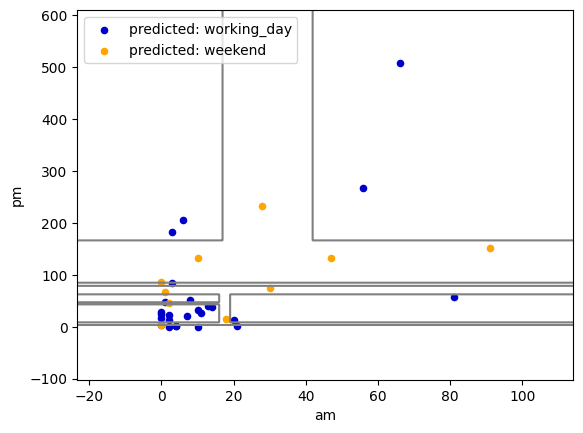

In [23]:
df['prediction'] = le.inverse_transform(best_model.predict(scaled_X))

fig, ax = plt.subplots()
df[df['prediction'] == 'working_day'].plot.scatter(x='am', y='pm', color='mediumblue', label='predicted: working_day', ax=ax)
df[df['prediction'] == 'weekend'].plot.scatter(x='am', y='pm', color='orange', label='predicted: weekend', ax=ax)
ax.contour(xx_real, yy_real, Z, levels=[0.5], colors='grey')
plt.legend()
plt.show()

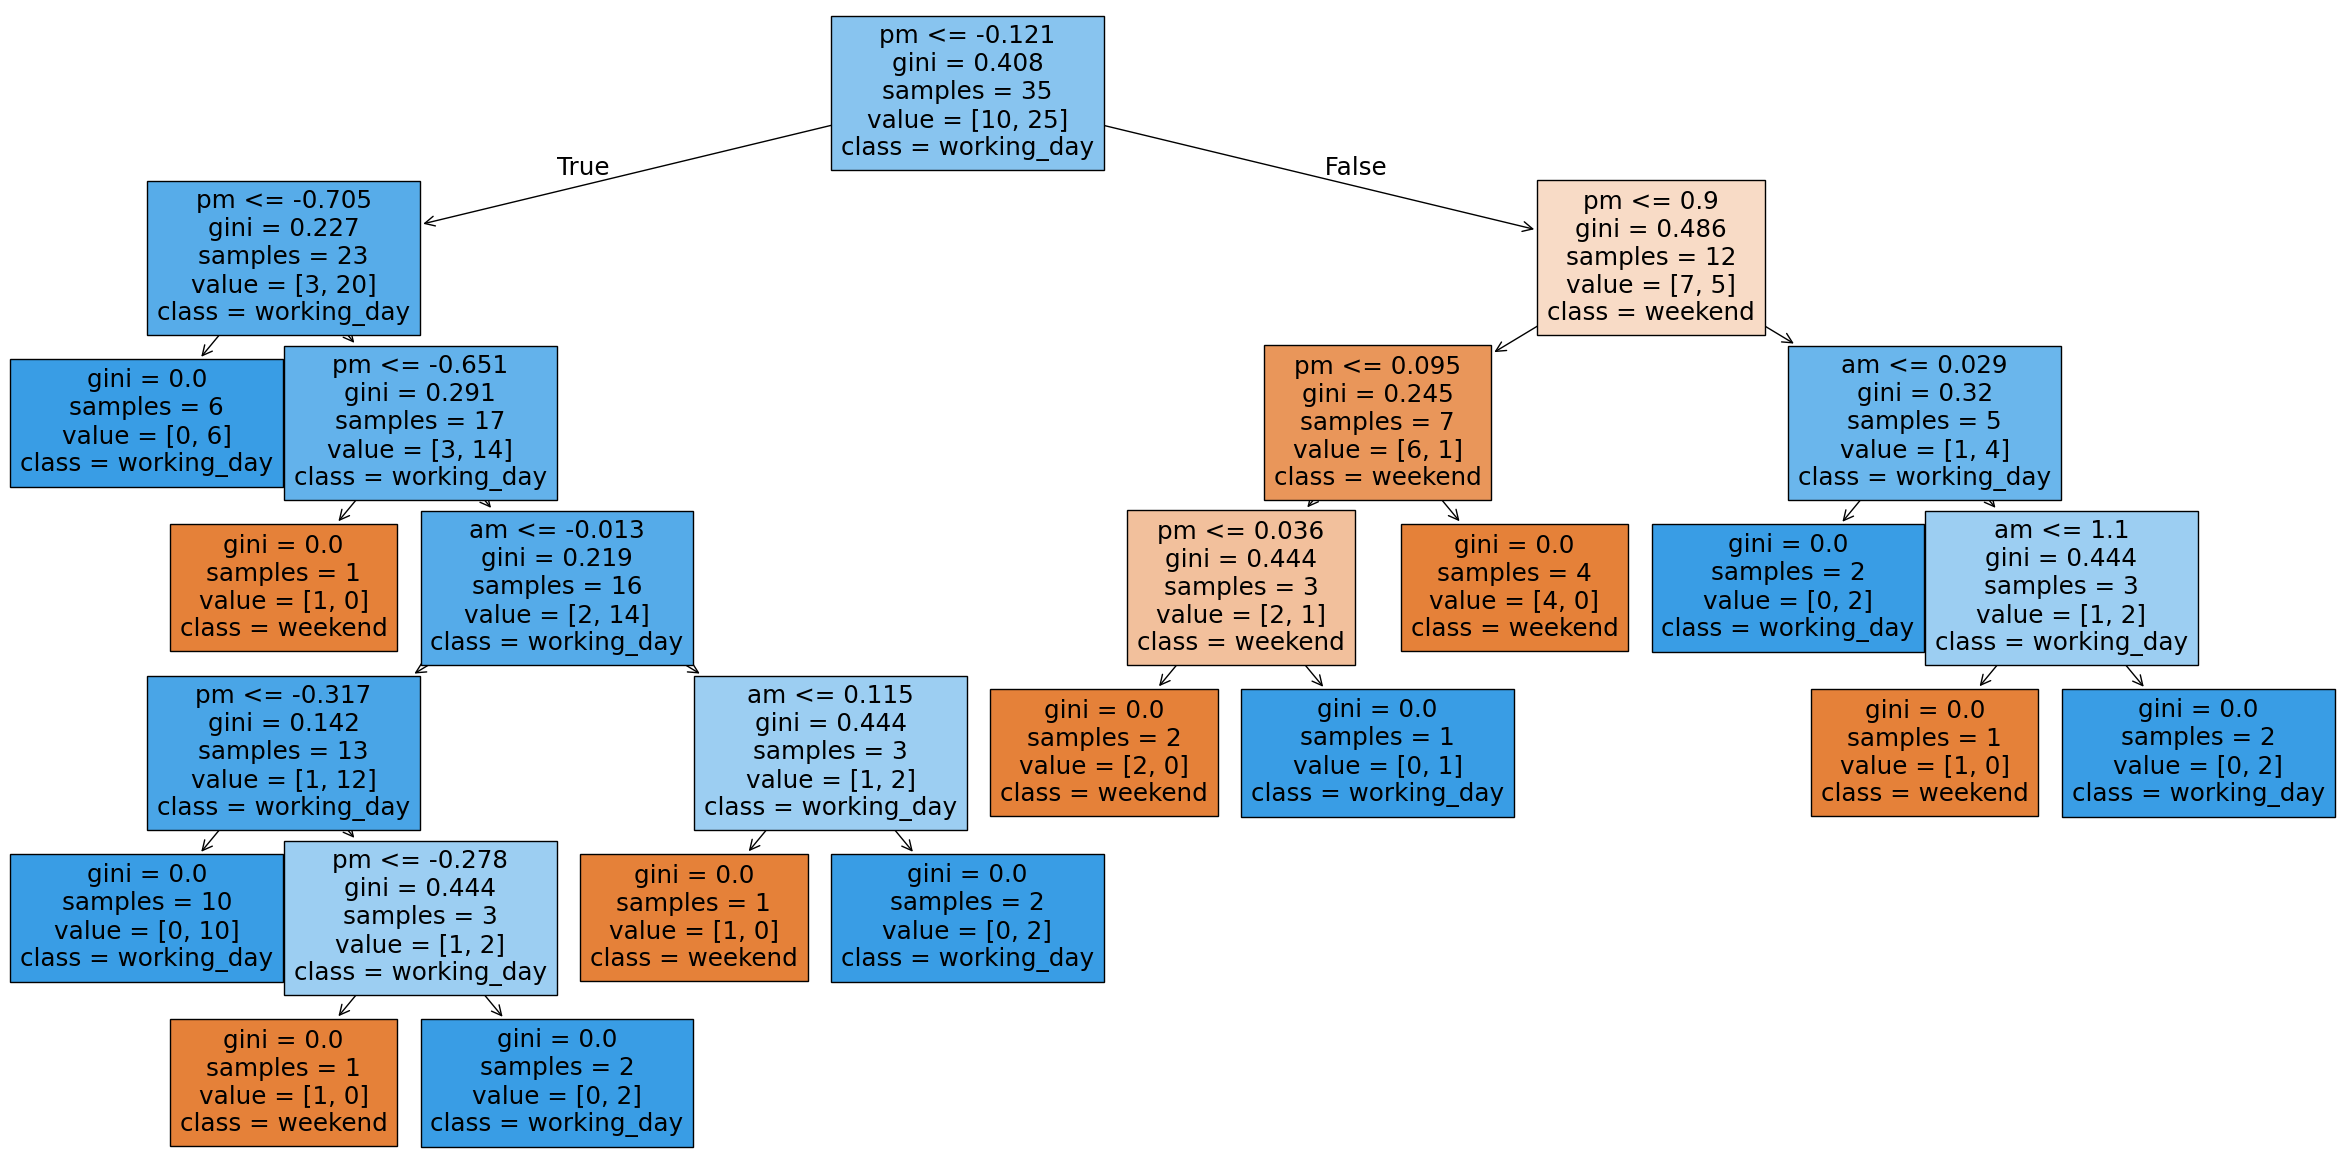

In [24]:
plt.figure(figsize=(30,15))
plot_tree(best_model, feature_names=['am', 'pm'], class_names=le.classes_, filled=True)
plt.show()

ANSWER: 7